<a href="https://colab.research.google.com/github/nicolasreyes490/proyectoFinalML/blob/main/ProyectoFinalMachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto Final Machine Learning**

## Temática: Calidad del Aire en Curicó

Autor: Nicolás Reyes

Profesor: Cesar Astudillo

Fecha: 18 de diciembre de 2021 

## **Contexto**

La contaminación atmosférica es una de las preocupaciones ambientales más importantes en muchos países del mundo, y se ve fuertemente afectada por las condiciones meteorológicas. 

El objetivo de este notebook, es desarrollar un proyecto de Machine Learning que permita generar pronósticos para la calidad del aire de una ciudad, especificamente Curicó. A continuación se describe paso a paso el proyecto en cuestión.

En primer lugar cargamos las librerias necesarias para trabajar con datos, gráficos, arreglos, modelos de pronósticos y algunas funcionalidades útiles. 

In [166]:
# cargamos librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
import warnings

# definimos algunos estilos y omisión de warnings
%matplotlib inline
sns.set(style="ticks")
warnings.filterwarnings('ignore')

### **Cargamos el Conjunto de Datos**

El conjunto de datos corresponde a una recopilación de valores de contaminación (material particulado) de la ciudad de Curicó. Estos datos corresponden a muestras tomadas desde el año 2012 a 2021. Estos se cargan mediante el link directo como se muestra a continuación: 

In [167]:
# accedemos directamente mediante el link
url="https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=xcl&macro=./RVII/709/Cal/PM25//PM25.horario.horario.ic&from=120707&to=211130&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath="

# guardamos los datos del archivo .csv en un dataframe df
df = pd.read_csv(url,parse_dates=[1],sep=';')

# imprimimos algunas caracteristicas principales del conjunto de datos
print("\n %%================   INFORMACION GENERAL   ================%%")
df.info()


 %%================   INFORMACION GENERAL   ================%%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82415 entries, 0 to 82414
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FECHA (YYMMDD)          82415 non-null  int64  
 1   HORA (HHMM)             82415 non-null  object 
 2   Registros validados     57743 non-null  object 
 3   Registros preliminares  16484 non-null  object 
 4   Registros no validados  2743 non-null   object 
 5   Unnamed: 5              0 non-null      float64
dtypes: float64(1), int64(1), object(4)
memory usage: 3.8+ MB


Como podemos observar el dataframe cuenta con 82415 filas y 6 columnas, que corresponden a lo siguiente:

**FECHA (YYMMDD):** Fecha de toma de datos

**HORA (HHMM):** Hora de toma de datos

**Registros validados:** Valores de contaminación 

**Registros preliminares:** Valores de contaminación 

**Registros no validados:** Valores de contaminación

Cada fila corresponde a una muestra de contaminación efectuada en una fecha y hora respectiva. No obstante, también es posible ver que existen datos nulos en las columnas de registros.


Para verificar cuantos valores nulos existen en cada columna de registros, realizamos lo siguiente:

In [168]:
print("%%================   VALORES NULOS   ===================%%")
print("Registros Validados:     ",df['Registros validados'].isnull().sum())
print("Registros Preliminares:  ",df['Registros preliminares'].isnull().sum())
print("Registros No Validados:  ",df['Registros no validados'].isnull().sum())

%%================   VALORES NULOS   ===================%%
Registros Validados:      24672
Registros Preliminares:   65931
Registros No Validados:   79672


Veremos las primeras filas del dataframe con el objetivo de ver en la forma que vienen los datos.

In [169]:
print("%%===================    PRIMERAS FILAS   ===================%%")
df.head()

%%===================    PRIMERAS FILAS   ===================%%


,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados,Unnamed: 5
0,120707,0100,NaN,NaN,NaN,NaN
1,120707,0200,NaN,NaN,NaN,NaN
2,120707,0300,NaN,NaN,NaN,NaN
3,120707,0400,NaN,NaN,NaN,NaN
4,120707,0500,NaN,NaN,NaN,NaN


### **Preprocesado de Datos**

Como podemos ver, las fechas y horas no se encuentran en un formato de este tipo, y de hecho son valores enteros, además de la existencia de valores nulos. Por esta razón, realizamos un preprocesado de los datos con el objetivo de primero transformar le fecha y hora en unidades de tiempo y el valor de contaminación en un número de tipo real. Además, se obtiene un dataframe de dos columnas una con fecha y hora unificada, y otra con el valor de contaminación.

Este preprocesado demora un poco (cerca de un minuto y medio), ya que se realiza muestra por muestra.

In [170]:
lista_fechas=[]
lista_contaminacion = []
filas_df, columnas_df = df.shape
for i in range(0,filas_df):
  fecha = str(df.iloc[i][0])
  formato_fecha = fecha[4]+fecha[5]+"-"+fecha[2]+fecha[3]+"-20"+fecha[0]+fecha[1]
  hora = str(df.iloc[i][1])
  formato_hora = hora[0]+hora[1]+":"+hora[2]+hora[3]
  formato_completo = formato_fecha+" "+formato_hora
  formato_completo = datetime.strptime(formato_completo, '%d-%m-%Y %H:%M')
  lista_fechas.append(formato_completo)

  if pd.isnull(df.iloc[i][2])== True and pd.isnull(df.iloc[i][3])== True and pd.isnull(df.iloc[i][4])==True:
    lista_contaminacion.append(np.nan)
  elif pd.isnull(df.iloc[i][2])==False:
    lista_contaminacion.append(df.iloc[i][2])
  elif pd.isnull(df.iloc[i][3])==False:
    lista_contaminacion.append(df.iloc[i][3])
  elif pd.isnull(df.iloc[i][4])==False:
    lista_contaminacion.append(df.iloc[i][4])

for i in range(0,filas_df):
  lista_contaminacion[i]=str(lista_contaminacion[i]).replace(',','.')

dataset = pd.DataFrame()
dataset=dataset.assign(FECHACOMPLETA=lista_fechas)
dataset=dataset.assign(CONTAMINACION=lista_contaminacion)
dataset['CONTAMINACION']=dataset['CONTAMINACION'].astype(float)

Un segundo paso, es verificar cuántos valores nulos hay por año, que es realizado a continuación.

%%===================    VALORES NULOS POR AÑO    ==================%%
 Año:  2012 , Valores Nulos:  2682
 Año:  2013 , Valores Nulos:  1717
 Año:  2014 , Valores Nulos:  141
 Año:  2015 , Valores Nulos:  357
 Año:  2016 , Valores Nulos:  207
 Año:  2017 , Valores Nulos:  57
 Año:  2018 , Valores Nulos:  81
 Año:  2019 , Valores Nulos:  43
 Año:  2020 , Valores Nulos:  81
 Año:  2021 , Valores Nulos:  79


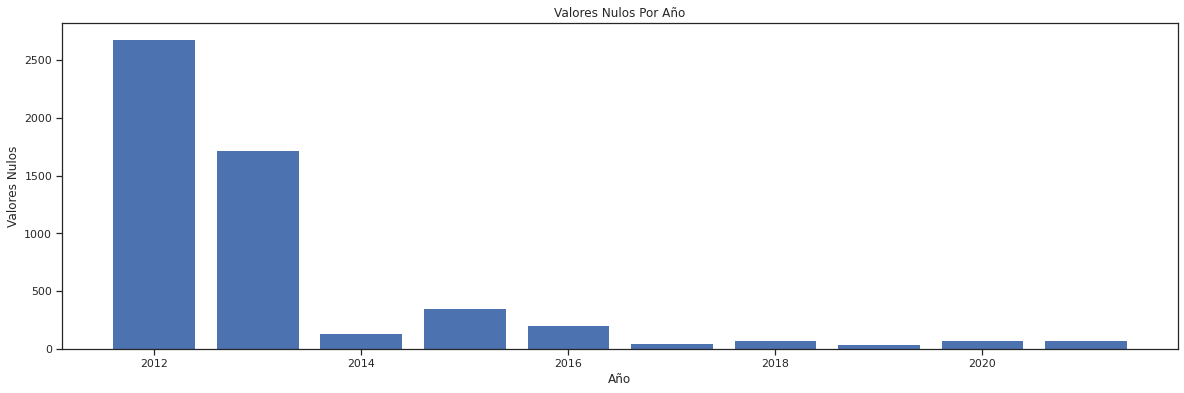

In [171]:
filas_dataset, col_dataset = dataset.shape

datos_faltAnio = {}

for i in range(dataset['FECHACOMPLETA'].dt.year[0],dataset['FECHACOMPLETA'].dt.year[filas_dataset-1]+1):
  datos_faltAnio[i] = 0

for i in range(0,filas_dataset):
  if pd.isnull(dataset.iloc[i][1])==True:
    datos_faltAnio[dataset['FECHACOMPLETA'].dt.year[i]] = datos_faltAnio[dataset['FECHACOMPLETA'].dt.year[i]] + 1
  
print("%%===================    VALORES NULOS POR AÑO    ==================%%")
for anio in datos_faltAnio:
  print(" Año: ",anio,", Valores Nulos: ",datos_faltAnio[anio])

# igualmente graficamos los valores
fig, ax = plt.subplots(figsize=(20,6))
ax.bar(list(datos_faltAnio.keys()),list(datos_faltAnio.values()))
plt.title('Valores Nulos Por Año')
plt.ylabel('Valores Nulos')
plt.xlabel('Año')
plt.show()

Como podemos ver, los primeros año presentan una cantidad importante de muestras con valor nulo, principalmente los años 2012 y 2013, entre los dos un 5,3% del total de 82415 muestras. El resto de años presentan valores nulos, no obstante son en menor cantidad.

Considerando el escenario anterior, se prefiere eliminar o sacar del dataframe los datos de los años 2012 y 2013, ya que imputar sus valores podría introducir sesgos en los resultados. Además, contamos con datos suficientes de 8 años resultantes para realizar un pronósticos. 

Los datos nulos de los años siguientes también son eliminados, ya que son pocos, representando menos del 1% de las 82415 muestras, y la imputación casi no tendría impacto.

De esta forma, eliminamos los nulos a continuación:

In [172]:
# eliminamos los años 2012 y 2013
dataset = dataset.drop(dataset[dataset['FECHACOMPLETA'].dt.year==2012].index)
dataset = dataset.drop(dataset[dataset['FECHACOMPLETA'].dt.year==2013].index)

# eliminamos los nulos de 2014 a 2021
dataset = dataset.drop(dataset[pd.isnull(dataset.CONTAMINACION) == True].index)

# reseteamos el indice desde 0 en adelante y eliminamos el indice antiguo
dataset = dataset.reset_index(drop=True)            

Entonces ahora, visualizamos como quedaron los datos imprimiendo las primeras 7 filas del dataframe:


In [173]:
dataset.head(7)

,FECHACOMPLETA,CONTAMINACION
0,2014-01-01 00:00:00,7.0
1,2014-01-01 01:00:00,4.0
2,2014-01-01 02:00:00,4.0
3,2014-01-01 03:00:00,4.0
4,2014-01-01 04:00:00,4.0
5,2014-01-01 05:00:00,5.0
6,2014-01-01 06:00:00,7.0


Ahora que tenemos los datos preprocesados, podemos trabajar con ellos para generar pronósticos. Pero antes, exploremos o visualicemos sus características graficando la serie de tiempo a continuación. 

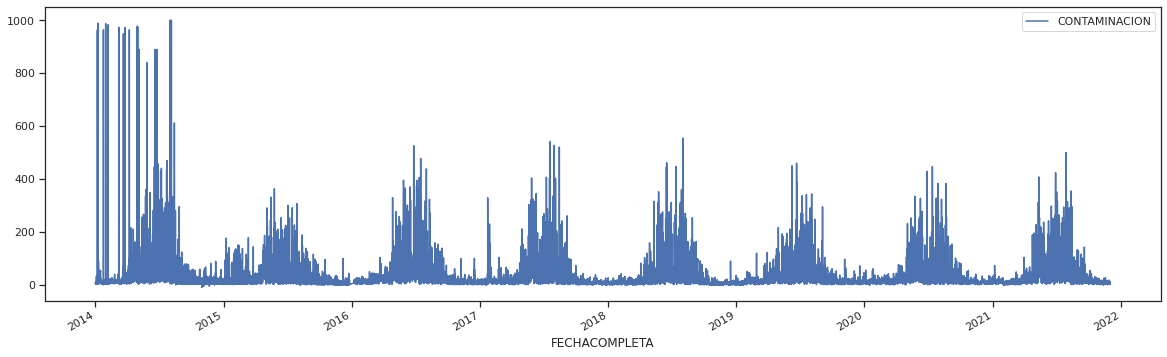

In [174]:
fig, ax = plt.subplots(figsize=(20,6))
dataset.plot(x="FECHACOMPLETA", y="CONTAMINACION", ax=ax)
plt.legend(loc='upper right')

Se puede observar que la serie de tiempo presenta un cierto comportamiento con una tendencia, una característica ciclica, y una estacionalidad. Donde se destacan visualmente los peak de contaminación en cada año. Estos peaks, se producen en los peridodos centrales de cada año que corresponden a los meses de invierno, donde precisamente existe mayor contaminación. Para mayor información consulte en el link a continuación: https://sinca.mma.gob.cl/index.php/estacion/index/id/269

También, se puede ver que el año 2014 hubo casos más críticos de contaminación, sobretodo la primera parte de este año. Precisamente, en ese año se comenzó a tomar medidas más efectivas para reducir la contaminación atmosférica como se señala en los siguientes artículos:

https://mma.gob.cl/disminuyen-episodios-criticos-por-contaminacion-atmosferica-en-curico/

https://mma.gob.cl/wp-content/uploads/2014/08/articles-56174_Plan_Maule.pdf





En este punto debemos decidir si trabajar directamente con estos datos, o bien agrupar los datos por días. Como lo que nos interesa es realizar pronósticos sobre calidad del aire, podemos utilizar sin problemas datos por día (por ejemplo, el promedio) en vez de datos horarios (esto solo sería importante si quisieramos considerar un pronóstico dentro del día, en alguna hora específica).

Primero comenzaremos agrupando los datos horarios, mediante el promedio diario, como se muestra a continuación:

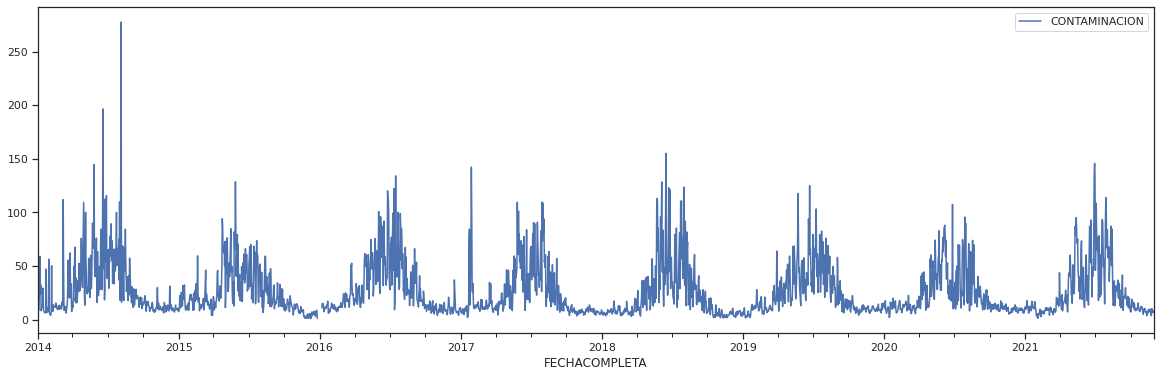

In [175]:
# agrupamos los datos por día usando el promedio
dataset_diario = dataset.set_index('FECHACOMPLETA').resample('D').mean()
dataset_diario.reset_index(inplace=True)

# graficamos la serie de tiempo
fig, ax = plt.subplots(figsize=(20,6))
dataset_diario.plot(x="FECHACOMPLETA", y="CONTAMINACION", ax=ax)
plt.legend(loc='upper right')

En este último gráfico podemos notar que existe un anomalía en el verano de 2017, coincidente con una emergencia de incendios forestales de esa época reportados en varias regiones de Chile. Se adjuntan algunos artículos sobre el tema que justifica en parte esos niveles de contaminación y merma de calidad del aire en Curicó.

https://www.odepa.gob.cl/wp-content/uploads/2017/12/incendios2017.pdf

http://dx.doi.org/10.4067/riatvol7iss1pp18-24%250718-235X



Realizamos un zoom en rango de fechas de 2019 a 2020, para ver a detalle la serie de tiempo en ese periodo

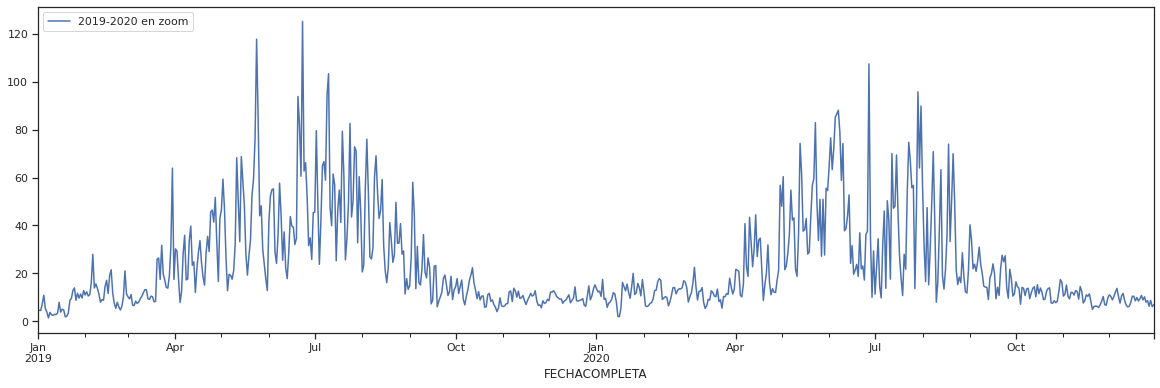

In [176]:
# definimos un rango de fecha para graficar este periodo
zoom_rango = dataset_diario[(dataset_diario.FECHACOMPLETA >= '2019-01-01') & (dataset_diario.FECHACOMPLETA <= '2020-12-30')].index

# graficamos el rango de la serie de tiempo
fig, ax = plt.subplots(figsize=(20,6)) 
dataset_diario.loc[zoom_rango].plot(x="FECHACOMPLETA", y="CONTAMINACION", ax=ax, label="2019-2020 en zoom") 
plt.legend(loc='upper left') 

De acuerdo a las visualizaciones, podemos notar que en general en las épocas de verano o de fin de año y comienzo del sguiente se registran la menor contaminación. Caso contrario, en meses de invierno donde crece de forma abrupta.

### **Tendencia y Estacionalidad**

Es evidente que la contaminación tiene fluctuaciones periodicas en cada año, y eventualmente también dentro de un año como podría ser en meses e incluso en días. Además, se observo que existe una tendencia en la serie, que va aumentando y disminuyendo (pero no de forma agresiva).  

Por lo anterior, podemos concluir en un inicio que tiene componentes de tendencia y estacionalidad anual (y en periodos más cortos), que podemos descomponer a continuación.

In [177]:
# meses de estacionalidad
decompfreq = 12
model = 'additive'

decomposition = seasonal_decompose(
    dataset_diario.set_index("FECHACOMPLETA").CONTAMINACION.interpolate("linear"),
    freq=decompfreq,
    model=model)

Obtenemos los resultados de la descomposición de la serie de tiempo, ósea su tendencia, estacionalidad y residuos

In [178]:
tendencia = decomposition.trend
estacionalidad = decomposition.seasonal 
residuo = decomposition.resid 

Ahora graficamos la tendencia, y vemos que nos entrega

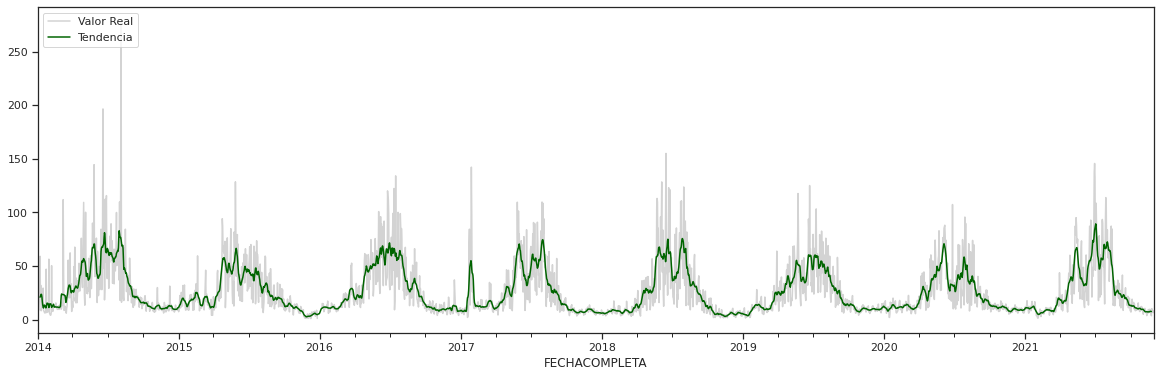

In [179]:
fig, ax = plt.subplots(figsize=(20,6))
dataset_diario.plot(x="FECHACOMPLETA", y="CONTAMINACION", ax=ax, label="Valor Real", c='lightgrey')
tendencia.plot(ax=ax, label="Tendencia", color="darkgreen") 
plt.legend(loc='upper left')

Graficamos la estacionalidad de la serie de tiempo, y obtenemos

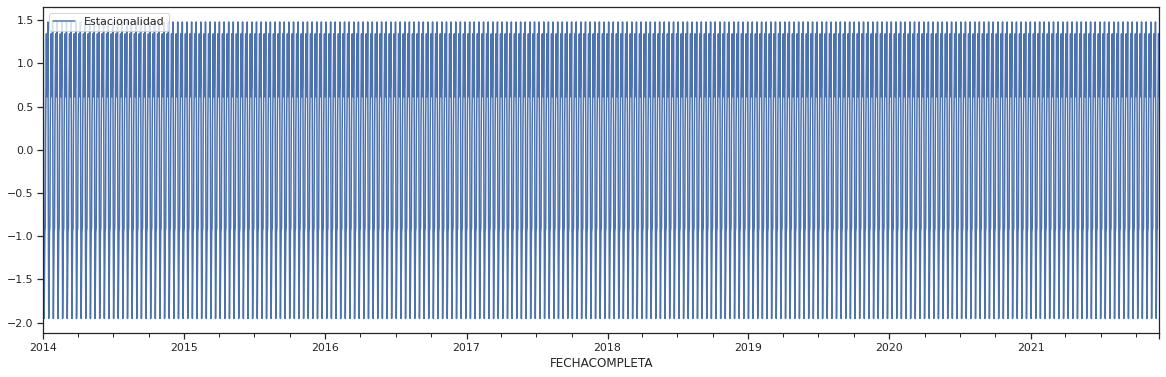

In [180]:
fig, ax = plt.subplots(figsize=(20,6))
estacionalidad.plot(ax=ax, label="Estacionalidad") 
plt.legend(loc='upper left')

Puesto que la curva se encuentra muy junta, utilizamos el rango para hacer zoom y ver a detalle la estacionalidad.

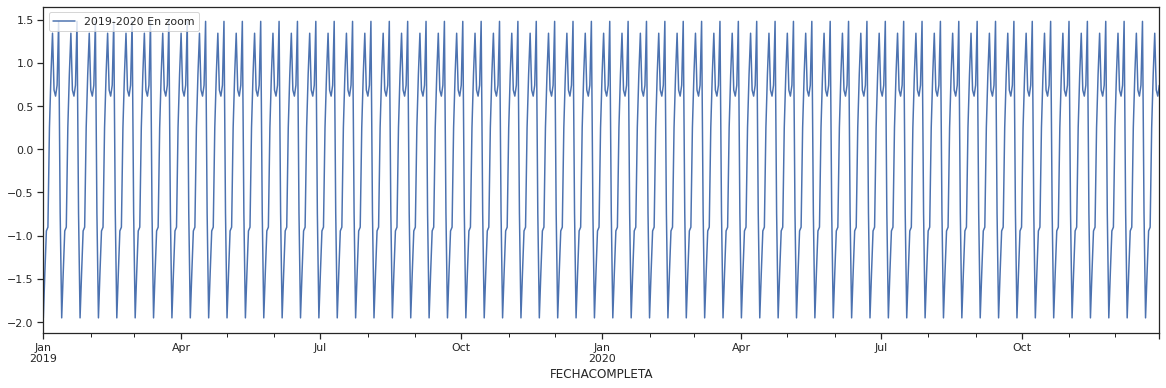

In [181]:
fig, ax = plt.subplots(figsize=(20,6))
estacionalidad[zoom_rango].plot(x="FECHACOMPLETA", y="CONTAMINACION", ax=ax, label="2019-2020 En zoom")
plt.legend(loc='upper left')

Y finalmente obtenemos el residuo de la serie.

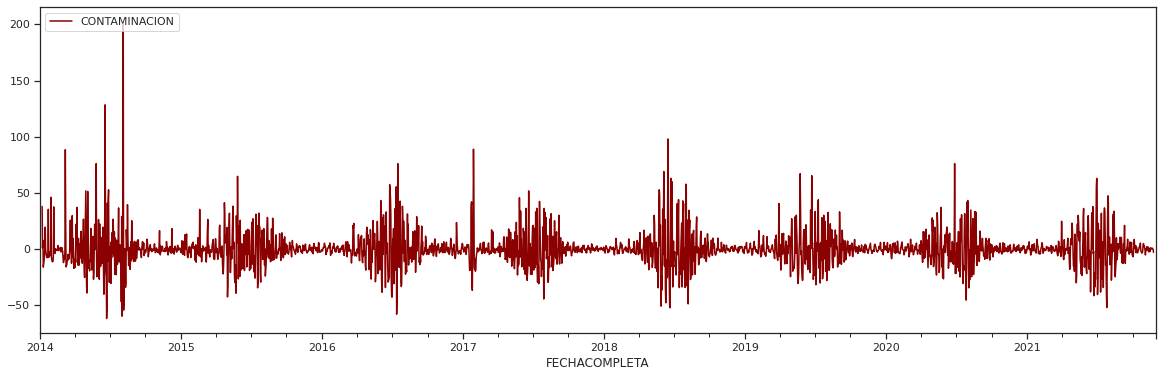

In [182]:
fig, ax = plt.subplots(figsize=(20,6))
residuo.plot(ax=ax, legend="Residuo", color="darkred") 
plt.legend(loc='upper left')

## **Modelo de Prophet**

Para comenzar a utilizar Prophet, dividimos los datos de entrenamiento y test. Para entrenar escogemos desde 2014 a 2019, mientras para test de 2020 a 2021

In [183]:
train_rango = dataset_diario[dataset_diario.FECHACOMPLETA <= '2019-12-30'].index
test_rango = dataset_diario[(dataset_diario.FECHACOMPLETA >= '2020-01-01')].index

Ahora visualizamos que datos de la serie son para entrenamiento y para test

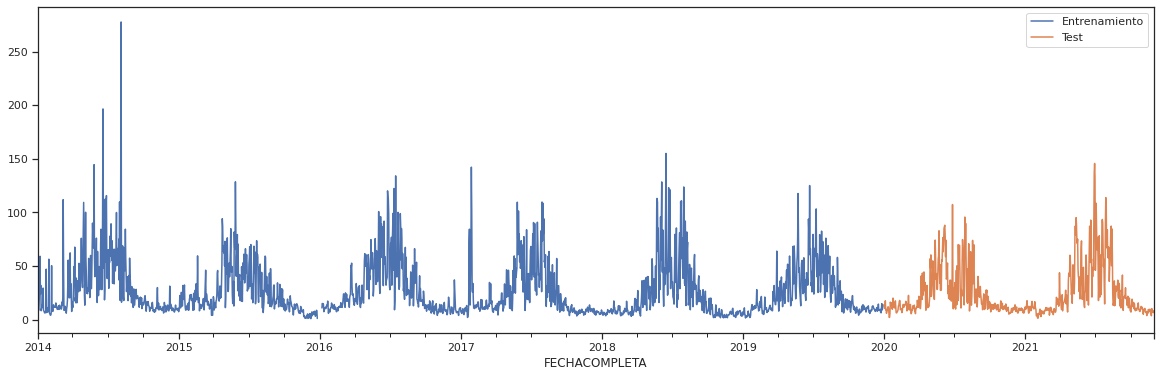

In [184]:
fig, ax = plt.subplots(figsize=(20,6))
dataset_diario.loc[train_rango].plot(x="FECHACOMPLETA", y="CONTAMINACION", ax=ax, label="Entrenamiento")
dataset_diario.loc[test_rango].plot(x="FECHACOMPLETA", y="CONTAMINACION", ax=ax, label="Test")

Ahora, definimos el modelo a utilizar con Prophet, con sus respectivos parámetros

In [185]:
df_prophet_train = dataset_diario.loc[train_rango][["FECHACOMPLETA", "CONTAMINACION"]]
df_prophet_train.columns = ["ds", "y"]

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    mcmc_samples=12,
    growth='linear',
    interval_width=0.9)

Luego entrenamos el modelo Prophet para construir posteriormente los pronósticos

In [186]:
model.fit(df_prophet_train)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Una vez entrenado el modelo, podemos realizar pronósticos, como se muestra en los siguientes pasos.

In [187]:
df_prophet_test = dataset_diario.loc[test_rango][["FECHACOMPLETA", "CONTAMINACION"]]
df_prophet_test.columns = ["ds", "y"]

forecast = model.predict(df_prophet_test[['ds']])
forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

yhat_test = forecast.yhat.values
y_test = dataset_diario.loc[test_rango].CONTAMINACION.values

Entonces, ahora graficamos los componentes obtenidos con el respectivo modelo

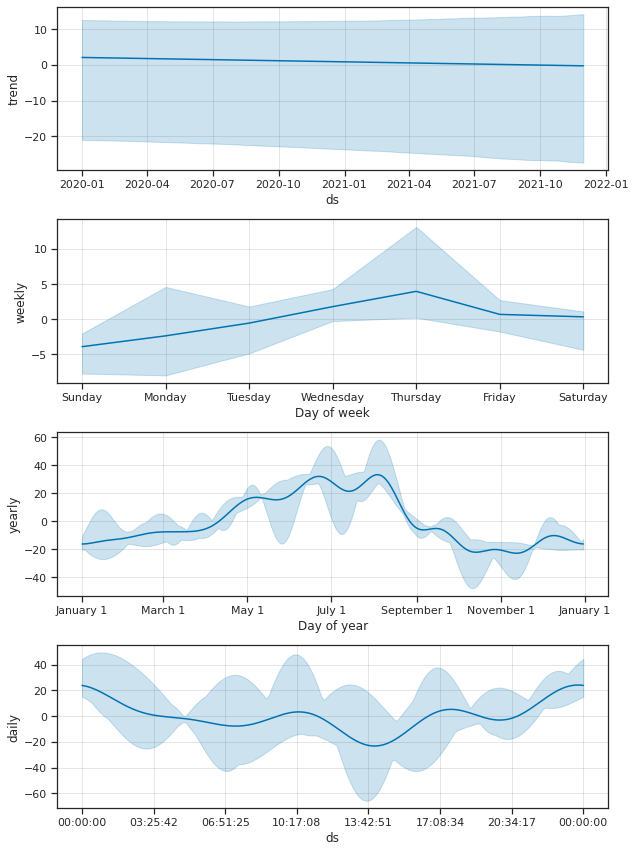

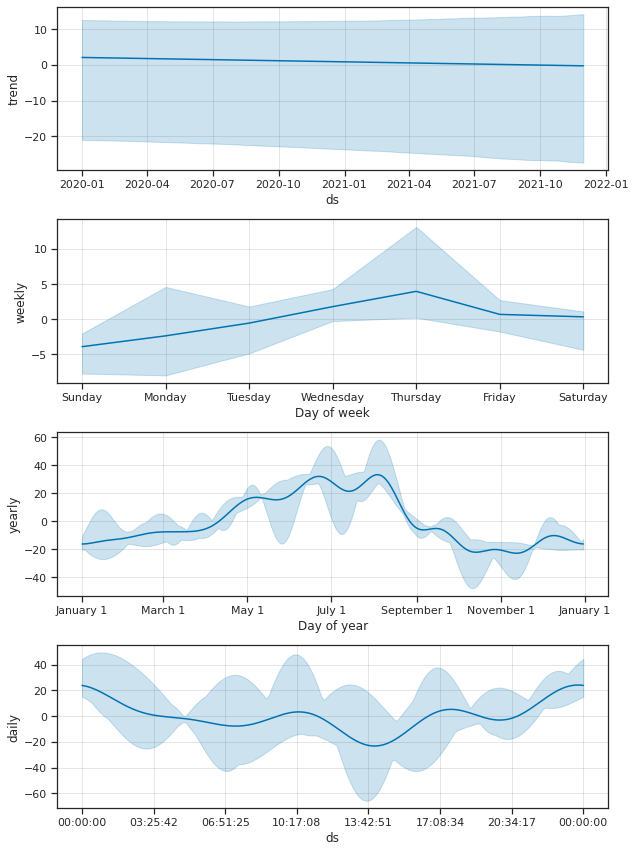

In [188]:
model.plot_components(forecast)

Construimos curvas para comparar los valores pronósticados y los reales (observados)

Text(0.5, 1.0, 'Real V/S Pronóstico (predicción)')

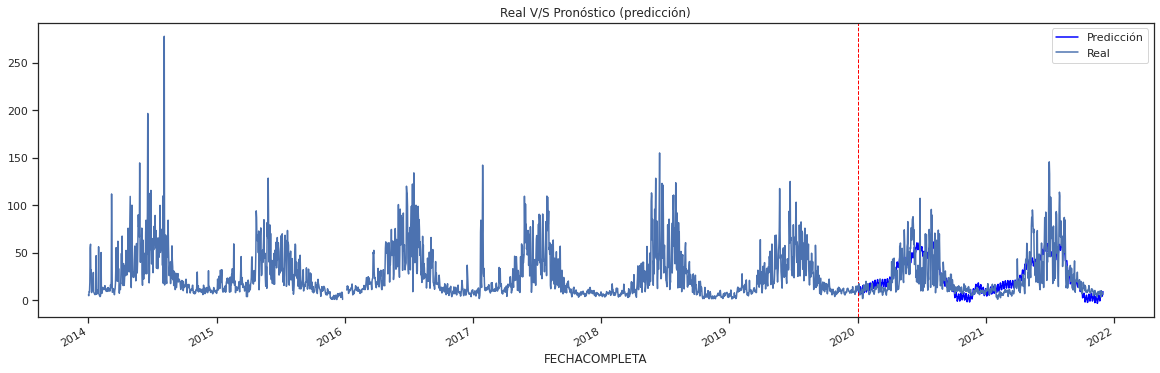

In [189]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(pd.to_datetime(dataset_diario.loc[test_rango].FECHACOMPLETA.values), yhat_test,
        color="blue", label="Predicción")

plt.axvline(pd.to_datetime(str(dataset_diario.loc[test_rango].FECHACOMPLETA.values[0])), c='red', ls='--', lw=1)
dataset_diario.plot(x="FECHACOMPLETA", y="CONTAMINACION", ax=ax, label="Real")

plt.legend(loc='best')
plt.title('Real V/S Pronóstico (predicción)')

En el gráfico anterior, podemos ver que los predicciones se acercan bastante a los valores observados (valores reales). Ahora nos acercamos a los datos de test, y ver con un zoom que esta sucediendo.

Text(0.5, 1.0, 'Real V/S Pronóstico (predicción)')

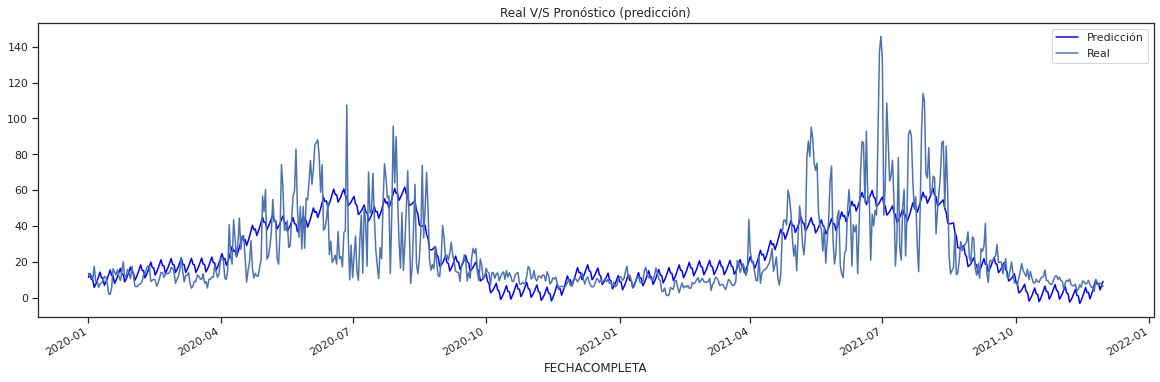

In [190]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(pd.to_datetime(dataset_diario.loc[test_rango].FECHACOMPLETA.values), yhat_test,
        color="blue", label="Predicción")

dataset_diario.loc[test_rango].plot(x="FECHACOMPLETA", y="CONTAMINACION", ax=ax, label="Real")
plt.legend(loc='best')
plt.title('Real V/S Pronóstico (predicción)')

Podemos ver que la curva de pronóstico es una curva mayormente representativa, de los valores observados. Si bien, no es idéntica igualmente se acerca a un promedio o linea media.

Ahora obtendremos los resultados (de test), además graficando un intervalo de confianza

Text(0.5, 1.0, 'Intervalo de confianza para el rango de test')

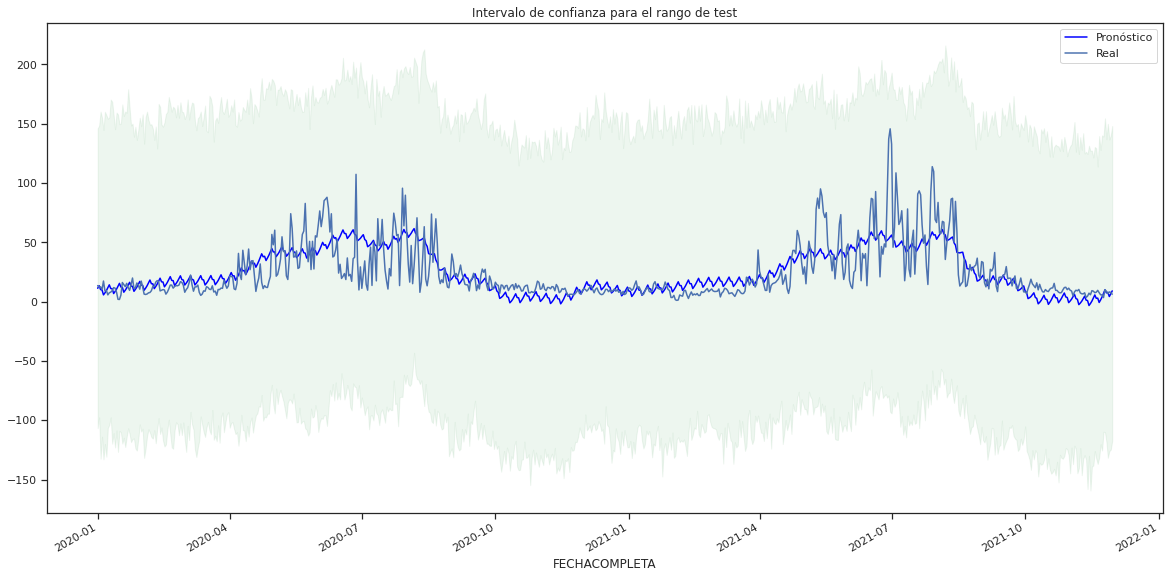

In [191]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(pd.to_datetime(dataset_diario.loc[test_rango].FECHACOMPLETA.values), yhat_test,
        color="blue", label="Pronóstico")

ax.fill_between(
    forecast_ci.index.to_pydatetime(),
    forecast_ci['yhat_lower'],
    forecast_ci['yhat_upper'],
    color='g',
    alpha=0.1)

dataset_diario.loc[test_rango].plot(x="FECHACOMPLETA", y="CONTAMINACION", ax=ax, label="Real")

plt.legend(loc='best')
plt.title('Intervalo de confianza para el rango de test')

## **Evaluación del modelo mediante algunas métricas**

Consideramos algunas métricas clásicas para evaluar el desempeño, como: el error cuadrático medio, error absoluto medio, el coeficiente de determinación, entr otros. 

In [192]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def theils_u_metric(y_true, y_pred):
    """Calculate Theil's U statistics using observed and predicted vectors."""
    SS_res =  np.mean(np.square(y_true - y_pred))
    SS_true = np.mean(np.square(y_true))
    SS_pred = np.mean(np.square(y_pred))
    
    return np.sqrt(SS_res / (SS_true * SS_pred))

mae = mean_absolute_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)
r2 = r2_score(y_test, yhat_test)
u = theils_u_metric(y_test, yhat_test)

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("U   (test): {:0.6f}".format(u))

MAE (test): 11
MSE (test): 266
R2  (test): 0.506
U   (test): 0.015432


Podemos observar que los errores, en general presentados son bajos. Esto, tanto para MAE, MSE con un valor mayor dado que es muy sensible a errores (por ser al cuadrado), y R cuadrado. Por lo anterior, podemos establecer que es un modelo que comúnmente realiza predicciónes cercanas a las reales.

